<a href="https://colab.research.google.com/github/jakob-steuer/chemoinformatics_2025/blob/main/chemoinformatics_4_chemical_databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created with Google Gemini v2.5 Pro

In [ ]:
pip install rdkit requests pubchempy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 53.8 MB/s eta 0:00:00


# Databases

# Comparison of Substructure Search Algorithms

## Introduction to Substructure Search Algorithms
In chemoinformatics, a common task is to search a database of molecules to find those that contain a specific chemical substructure (a smaller part or fragment). This is a computationally intensive task that relies on solving the subgraph isomorphism problem.

**Brute-Force Search:** This is the simplest, but most inefficient, approach. It attempts to find a match by systematically checking every possible mapping of the query molecule's atoms and bonds onto the target molecule. Its complexity grows factorially, making it impractical for all but the smallest molecules.

**Backtracking Algorithm** (e.g., VF2): This is a much smarter approach. It builds a mapping between the query and target atoms one step at a time. If at any point it finds a mapping that violates the rules (e.g., an incorrect atom type or a missing bond), it "backtracks" to the previous step and tries a different path. This pruning of invalid search paths makes it vastly more efficient than a brute-force search. The RDKit library's default search algorithm is based on this principle.

## The Molecule Database and Query

First, let's define our small database of six molecules and the substructure we want to search for. For our exercise, we will search for a benzene ring.

In [41]:
from rdkit import Chem

# Step 1: Define the database and query
smiles_database = {
    'Ethanol': 'CCO',
    'Acetic Acid': 'CC(=O)O',
    'Toluene': 'Cc1ccccc1',
    'Phenol': 'c1ccc(O)cc1',
    'Aniline': 'c1ccc(N)cc1',
    'Cyclohexane': 'C1CCCCC1'
}

query_smiles = 'c1ccccc1' # Benzene ring

# Step 2: Create RDKit molecule objects
query_mol = Chem.MolFromSmiles(query_smiles)
db_mols = {name: Chem.MolFromSmiles(smi) for name, smi in smiles_database.items()}

In [42]:
%%time
print("--- Running Substructure Search ---")
print(f"Query: Benzene\n")

# Step 3: Iterate and search the database
match_count = 0
for name, mol in db_mols.items():
    # HasSubstructMatch uses an efficient backtracking algorithm (like VF2)
    has_match = mol.HasSubstructMatch(query_mol)
    if has_match:
        print(f"✅ Match found in: {name}")
        match_count += 1
    else:
        print(f"❌ No match in:   {name}")

print(f"\n--- Search Complete. Found {match_count} total matches. ---")

--- Running Substructure Search ---
Query: Benzene

❌ No match in:   Ethanol
❌ No match in:   Acetic Acid
✅ Match found in: Toluene
✅ Match found in: Phenol
✅ Match found in: Aniline
❌ No match in:   Cyclohexane

--- Search Complete. Found 3 total matches. ---
CPU times: user 1.37 ms, sys: 0 ns, total: 1.37 ms
Wall time: 1.14 ms


In [43]:
from rdkit import Chem
from itertools import permutations

def brute_force_search(target_mol, query_mol):
    """
    Performs a brute-force substructure search.

    Args:
        target_mol: The RDKit molecule to search within.
        query_mol: The RDKit query molecule.

    Returns:
        True if the query is a substructure of the target, False otherwise.
    """
    num_target_atoms = target_mol.GetNumAtoms()
    num_query_atoms = query_mol.GetNumAtoms()

    if num_query_atoms > num_target_atoms:
        return False

    # Generate all possible mappings of query atoms to a subset of target atoms
    target_atom_indices = range(num_target_atoms)
    for mapping in permutations(target_atom_indices, num_query_atoms):
        # `mapping` is a tuple where mapping[i] is the index of the target atom
        # that corresponds to the i-th query atom.
        # Example: mapping = (3, 0, 1, 5, 4, 2)

        is_valid_mapping = True
        # Check if this mapping preserves the bond structure
        for query_bond in query_mol.GetBonds():
            q_idx1 = query_bond.GetBeginAtomIdx()
            q_idx2 = query_bond.GetEndAtomIdx()

            # Find the corresponding atoms in the target molecule based on the current mapping
            t_idx1 = mapping[q_idx1]
            t_idx2 = mapping[q_idx2]

            # Check if a bond exists between these two atoms in the target molecule
            if target_mol.GetBondBetweenAtoms(t_idx1, t_idx2) is None:
                # If any bond is missing, this mapping is invalid
                is_valid_mapping = False
                break # Move to the next mapping

        # If we checked all bonds and they all exist, we found a match!
        if is_valid_mapping:
            return True

    # If we go through all possible permutations and find no valid mapping
    return False

In [44]:
%%time
# --- Re-run the search using our brute-force implementation ---

print("--- Running BRUTE-FORCE Substructure Search ---")
print(f"Query: Benzene\n")

match_count = 0
for name, mol in db_mols.items():
    has_match = brute_force_search(mol, query_mol)
    if has_match:
        print(f"✅ Match found in: {name}")
        match_count += 1
    else:
        print(f"❌ No match in:   {name}")

print(f"\n--- Search Complete. Found {match_count} total matches. ---")

--- Running BRUTE-FORCE Substructure Search ---
Query: Benzene

❌ No match in:   Ethanol
❌ No match in:   Acetic Acid
✅ Match found in: Toluene
✅ Match found in: Phenol
✅ Match found in: Aniline
✅ Match found in: Cyclohexane

--- Search Complete. Found 4 total matches. ---
CPU times: user 7.76 ms, sys: 0 ns, total: 7.76 ms
Wall time: 7.77 ms


# Substructure Search with SMARTS

## Use SMARTS to define a Struture

We will reuse our example from `Exercise 2 (Molecular Graphs): Subgraph Isomorphism Task`.

We will perform a subgraph isomorphism test for each molecule in a database and then generate an image highlighting the matches.

Query Graph: The phenylsulfonamide substructure.

We'll represent this using a SMARTS string: c1ccc(S(=O)(=O)N)cc1.

--- Visualizing the Query Substructure ---


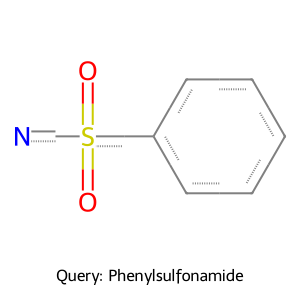

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

# The query substructure (phenylsulfonamide) as a SMARTS string
query_smarts = "c1ccc(S(=O)(=O)N)cc1"

# Convert the SMARTS string into a query molecule object
query_mol = Chem.MolFromSmarts(query_smarts)
query_mol.SetProp("_Name", "Query: Phenylsulfonamide")

print("--- Visualizing the Query Substructure ---")

# Draw the molecule. MolsToGridImage is used here for consistency,
# but Draw.MolToImage would also work for a single molecule.
img = Draw.MolsToGridImage(
    [query_mol],
    molsPerRow=1,
    subImgSize=(300, 300),
    legends=[query_mol.GetProp("_Name")] # Use the property as a legend
)

# Display the image in Jupyter by making it the last line of the cell
img

## Exercise 1

As discussed in the lecture, write a more general SMARTS query to find any sulfonamide attached to any 6-membered aromatic ring. Print the resulting molecule and compare it to the structure in the initial query.

In [ ]:
# --- YOUR CODE ---

## Load molecular database

We will test the two SMARTS strings on a small molecular database.

For this, first download the database file from github.

In [12]:
# Import database from github
!wget https://raw.githubusercontent.com/jakob-steuer/chemoinformatics_2025/refs/heads/main/molecules.smi

--2025-09-30 06:29:30--  https://raw.githubusercontent.com/jakob-steuer/chemoinformatics_2025/refs/heads/main/molecules.smi
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168 [text/plain]
Saving to: ‘molecules.smi.1’

molecules.smi.1     100%[===================>]     168  --.-KB/s    in 0s      

2025-09-30 06:29:30 (8.40 MB/s) - ‘molecules.smi.1’ saved [168/168]



## Exercise 2

Inspect the content of the database file you just downloaded.

There are many ways of how to do this!

In [18]:
# Open the smiles database
input_filename = "molecules.smi"
molecule_database = {}
mols = []
legends = []

# Open the file in read mode ('r')
with open(input_filename, 'r') as f:
    for line in f:
        if not line.strip():
            continue

        # Split the line into SMILES and name, add to database
        smiles, name = line.strip().split(maxsplit=1)
        molecule_database[name] = smiles

        # Create RDKit molecule object and add it to our list
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mols.append(mol)
            legends.append(name)

print("Successfully loaded molecules into dictionary:")
print(molecule_database)

Successfully loaded molecules into dictionary:
{'MOL_001': 'c1ccc(S(=O)(=O)N)cc1', 'MOL_002': 'Cc1ccc(S(=O)(=O)N)cc1', 'MOL_003': 'Clc1cc(S(=O)(=O)N)ccc1Cl', 'MOL_004': 'n1cccc(S(=O)(=O)N)c1', 'MOL_005': 'c1cncc(S(=O)(=O)N)c1', 'MOL_006': 'c1ccccc1N'}


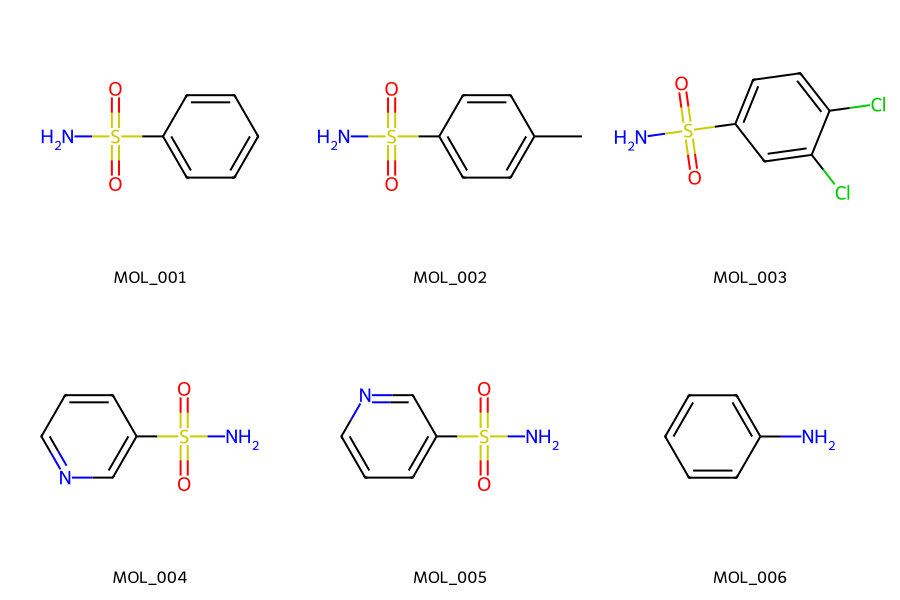

In [20]:
# Visualize the molecules in the database
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300), legends=legends)
img

## Exercise 3

Test both queries on the database.

- What do you expect will be the difference?

Searching for the phenylsulfonamide substructure...

✔️ Match found in: MOL_001
✔️ Match found in: MOL_002
✔️ Match found in: MOL_003
✔️ Match found in: MOL_004
✔️ Match found in: MOL_005
❌ No match in: MOL_006


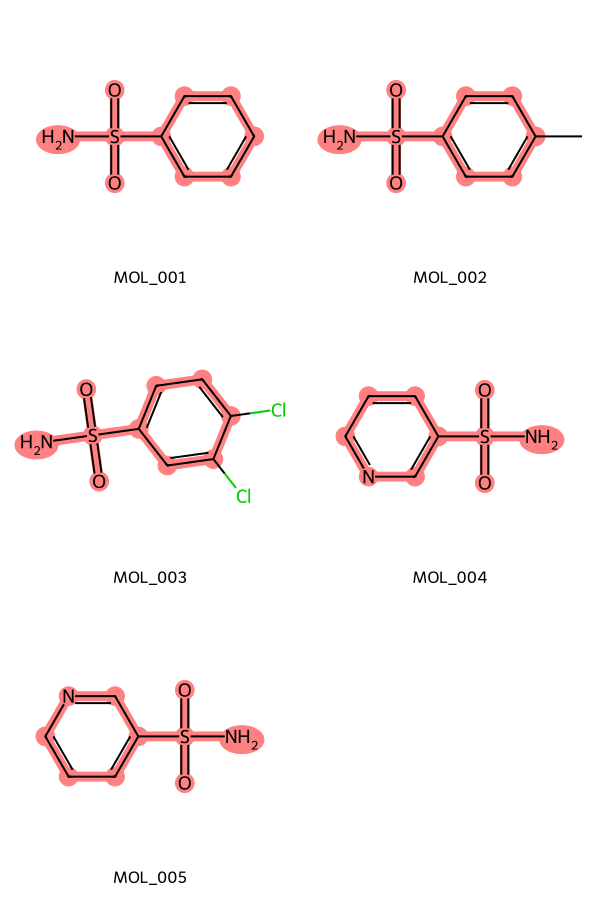

In [14]:
print(f"Searching for the phenylsulfonamide substructure...\n")

# Perform the Isomorphism Test
matching_molecules = []
matching_indices = []
molecule_names = []

for name, smiles in molecule_database.items():
    mol = Chem.MolFromSmiles(smiles)
    if mol.HasSubstructMatch(query_mol):
        print(f"✔️ Match found in: {name}")
        match_idx = mol.GetSubstructMatch(query_mol)
        matching_molecules.append(mol)
        matching_indices.append(match_idx)
        molecule_names.append(name)
    else:
        print(f"❌ No match in: {name}")

# Create the Image Object
if matching_molecules:
    img = Draw.MolsToGridImage(
        matching_molecules,
        molsPerRow=2,
        subImgSize=(300, 300),
        legends=molecule_names,
        highlightAtomLists=matching_indices
    )

img

# Explore the PubChem Database with PubChemPy

In [35]:
import pubchempy as pcp
from pubchempy import get_compounds
from pubchempy import Compound

## Exercise 4

We will use the PubChemPy package to retrieve information from the PubChem database.

The PubChemPy documentation is a great resource to solve the following tasks: https://docs.pubchempy.org/en/latest/


### **Task 1:**
Search for ibuprofen compound by name

In [26]:
# --- YOUR CODE GOES HERE ---

#### 🔍 Solution (Hidden - Expand to see the answer)

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

```
for compound in get_compounds('ibuprofen', 'name'):
    print(compound.cid)
    print(compound.isomeric_smiles)  
```

Instead of name, you could also use, smiles, sdf, inchi, inchikey or formula.
</details>

### **Task 2:**
Retrieve the calculated properties molecular_formula, molecular_weight, and xlogP for the compound

In [28]:
# --- YOUR CODE GOES HERE ---

#### 🔍 Solution (Hidden - Expand to see the answer)

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

```
compound = Compound.from_cid(3672)
print(compound.molecular_formula)
print(compound.molecular_weight)
print(compound.xlogp)
```

</details>

### **Task 3:**
Search for similar structures to L-Alanine (`C[C@@H](C(=O)O)N`)

In [30]:
# --- YOUR CODE GOES HERE ---

#### 🔍 Solution (Hidden - Expand to see the answer)

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

```
pcp.get_compounds('C[C@@H](C(=O)O)N', 'smiles', searchtype='superstructure', listkey_count=3)
```

</details>

### **Task 4:**
Get 3D record for Aspirin

In [32]:
# --- YOUR CODE GOES HERE ---

#### 🔍 Solution (Hidden - Expand to see the answer)

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

```
pcp.get_compounds('Aspirin', 'name', record_type='3d')
```

</details>

### **Task 5:**
Get the conformational energy of Aspirin using it’s 3D conformation

In [34]:
# --- YOUR CODE GOES HERE ---

#### 🔍 Solution (Hidden - Expand to see the answer)

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

```
pcp.get_compounds('Aspirin', 'name', record_type='3d')[0].mmff94_energy_3d
```

You can retrieve properties such as volume_3d, multipoles_3d, conformer_rmsd_3d, effective_rotor_count_3d, pharmacophore_features_3d, mmff94_partial_charges_3d, mmff94_energy_3d, conformer_id_3d, shape_selfoverlap_3d, feature_selfoverlap_3d, shape_fingerprint_3d

</details>

### **Task 6:**
Download and display PNG and CSV file for Aspirin

In [34]:
# --- YOUR CODE GOES HERE ---

#### 🔍 Solution (Hidden - Expand to see the answer)

<details>
<summary>Click here to see the solution after you've tried exploring the functions</summary>

```
pcp.download('PNG', 'asp.png', 'Aspirin', 'name')
pcp.download('CSV', 'asp.csv', [5090], operation='property/CanonicalSMILES,IsomericSMILES')
```

Format options: XML, ASNT/B, JSON, SDF, CSV, PNG, TXT

</details>

# Exploring Chemical Databases with APIs

In our lecture, we discussed how chemical databases like PubChem store information on millions of molecules. But how do we access this data from a script? We could download massive files, but a more efficient way is to use an Application Programming Interface, or API.

## API

The Restaurant Analogy

    Think of an API as a waiter in a restaurant.

    You (the client) want to get data from a web service (the kitchen).

    You don't go into the kitchen yourself. Instead, you give your order to the waiter (the API) using a structured format (the menu).

    The waiter takes your request to the kitchen, which prepares your order.

    The waiter then brings the data (the food) back to you.

For web-based databases, these requests are often made by constructing a special URL. This is known as a REST API.

## REST API

A REST API is a standardized way for computer systems to communicate with each other over the internet. REST stands for Representational State Transfer, and an API is an Application Programming Interface.

**How It Works: URLs as Requests**

A REST API works by constructing a specific URL to ask for data. This URL contains all the information the server needs to fulfill the request.

For example, to get the SMILES string for ethanol from PubChem, you would construct a URL like this:
https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/CCO/cids/txt

This URL is composed of several parts:

    Endpoint: https://pubchem.ncbi.nlm.nih.gov/rest/pug/ - The base address of the API.

    Path: /compound/smiles/CCO/cids - Specifies exactly what you want (the CID for the compound with the SMILES string "CCO").

    Output Format: /txt - Tells the server to return the data as plain text.

When you send this request (e.g., in a web browser or a Python script), the PubChem server sends back the requested data. This structured, URL-based approach is what makes REST APIs so powerful and easy to use for programmatic data access.

Today, we'll use the PubChem PUG-REST API to fetch data directly into our notebook.

## PUG-REST API
A more detailed introduction to the PUG-Rest API can be found here:

https://pubchem.ncbi.nlm.nih.gov//docs/pug-rest-tutorial#section=How-PUG-REST-Works

In [ ]:
# Import necessary libraries
import requests
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
import time
import json

## Identity Search: Fetching a Molecule by Name

The simplest query is a text search. Let's ask PubChem for the structure of "Aspirin" and some of its properties.

The API request is built into the URL. We'll ask for the molecule's SMILES string and its molecular weight.

In [ ]:
# The base URL for PubChem's API
base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

# Let's search for Aspirin by its name
compound_name = "Aspirin"

# First, get the SMILES string
smiles_url = f"{base_url}/compound/name/{compound_name}/property/CanonicalSMILES/txt"
smiles_response = requests.get(smiles_url)
aspirin_smiles = smiles_response.text.strip()

# Second, get the Molecular Weight
mw_url = f"{base_url}/compound/name/{compound_name}/property/MolecularWeight/txt"
mw_response = requests.get(mw_url)
aspirin_mw = mw_response.text.strip()

In [ ]:
print(f"--- Processed Data ---")
print(f"Name: {compound_name}")
print(f"SMILES: {aspirin_smiles}")
print(f"Molecular Weight: {aspirin_mw} g/mol")

# Now, let's visualize the structure using RDKit
aspirin_mol = Chem.MolFromSmiles(aspirin_smiles)
display(aspirin_mol)

### Exercise 5

Investigate what happens when you copy-paste the SMILES or Molecular Weight  URLs in a Browser

### Exercise 6

Extract the InChI, the InChIKey and two additional propertes of your choice (see the `Compound Property Tables` here: https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest) from the PubChem API.

## Substructure Search: Finding Molecules with a Specific Fragment

A more powerful query is a substructure search (SSS).

Let's find molecules in PubChem that contain the **coumarin** scaffold. It's a bicyclic structure that's the basis for many natural products and pharmaceuticals (like the anticoagulant Warfarin).

This is a two-step process:

- Send a request with the substructure (as a SMILES string). PubChem will start the search and give us a "ListKey" that acts as a ticket to our results.

- Use that ListKey to retrieve the actual compound IDs (CIDs) of the molecules that matched.

In [ ]:
# Step 1: Initiate the substructure search to get a ListKey

substructure_smiles = "C1=CC=C2C(=C1)C=CC(=O)O2"
base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
search_url = f"{base_url}/compound/substructure/smiles/{substructure_smiles}/JSON"

print("Sending search request to PubChem...")

try:
    # Initiate the search
    response = requests.post(search_url)
    response.raise_for_status()
    initial_data = response.json()

    if 'Waiting' not in initial_data:
        print("Error: Could not initiate search.")
        print("Server response:", initial_data)
    else:
        listkey = initial_data['Waiting']['ListKey']
        print(f"Search successfully initiated. Received ListKey: {listkey}")

        # Step 2: Poll the server until the results are ready
        retrieve_url = f"{base_url}/compound/listkey/{listkey}/cids/JSON"
        print("Polling server for results... (this may take a moment)")

        status = "Waiting"
        while status == "Waiting":
            # Wait for a couple of seconds between checks
            time.sleep(2)

            results_response = requests.get(retrieve_url)
            results_response.raise_for_status()
            results_data = results_response.json()

            # Check if the 'Waiting' key is still present in the response
            if 'Waiting' in results_data:
                print("...search is still running.")
            else:
                status = "Ready" # Exit the loop

        # Once the loop exits, the results are ready to be processed
        print("\n--- Search Complete! ---")

        if 'IdentifierList' in results_data:
            compound_ids = results_data['IdentifierList']['CID']
            print(f"Found {len(compound_ids)} molecules containing the catechol fragment.")
            print(f"Here are the first 10 Compound IDs (CIDs):")
            print(compound_ids[:10])
        else:
            print("Search finished, but no identifiers were found.")
            print("Server response:", results_data)

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
except KeyError as e:
    print(f"A key was not found in the response: {e}")

## Similarity Search: Finding Structurally Similar Molecules

Finally, let's perform a similarity search. We will find molecules that are structurally similar to Dopamine. This search relies on comparing molecular fingerprints.

The process is very similar to a substructure search.

In [ ]:
from rdkit.Chem import Draw

# Define our base URL and query molecule
base_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
dopamine_smiles = "C1=CC(=C(C=C1CCN)O)O"
dopamine_cid = 681 # Known CID for Dopamine

print("--- Step 1: Initiating Asynchronous Similarity Search ---")

# --- CORRECTED PART ---
# The SMILES and Threshold must be part of the URL itself for the POST request.
search_url = f"{base_url}/compound/similarity/smiles/{dopamine_smiles}/JSON?Threshold=95"
print(f"Using search URL: {search_url}")

try:
    # Initiate the search via POST to the constructed URL. The POST body is empty.
    response = requests.post(search_url)
    response.raise_for_status()
    initial_data = response.json()

    if 'Waiting' not in initial_data:
        print("Error: Could not initiate search.")
        print("Server response:", initial_data)
        listkey = None
    else:
        listkey = initial_data['Waiting']['ListKey']
        print(f"Search successfully initiated. Received ListKey: {listkey}")

    if listkey:
        # --- Step 2: Poll Server for Results ---
        retrieve_url = f"{base_url}/compound/listkey/{listkey}/cids/JSON"
        print("Polling server for results... (this may take a moment)")

        status = "Waiting"
        while status == "Waiting":
            time.sleep(2) # Wait between checks

            results_response = requests.get(retrieve_url)
            results_response.raise_for_status()
            results_data = results_response.json()

            if 'Waiting' in results_data:
                print("...search is still running.")
            else:
                status = "Ready"

        print("\n--- Search Complete! ---")

        # --- Step 3: Retrieve and Visualize Top Hits ---
        if 'IdentifierList' in results_data:
            # Get the top 5 similar compound IDs
            similar_cids = results_data['IdentifierList']['CID'][:5]
            print(f"Found top 5 similar CIDs: {similar_cids}")

            # Prepare CIDs for property fetching (Query + Hits)
            all_cids_to_draw = [str(dopamine_cid)] + [str(cid) for cid in similar_cids]
            cids_str = ",".join(all_cids_to_draw)

            # Fetch SMILES for all molecules in a single request
            properties_url = f"{base_url}/compound/cid/{cids_str}/property/CanonicalSMILES/JSON"
            prop_res = requests.get(properties_url)
            prop_data = prop_res.json()['PropertyTable']['Properties']

            # Create a dictionary of {CID: SMILES}
            cid_smiles_map = {item['CID']: item['CanonicalSMILES'] for item in prop_data}

            # Prepare data for RDKit, ensuring Dopamine is first
            mols_to_draw = [Chem.MolFromSmiles(cid_smiles_map[cid]) for cid in [dopamine_cid] + similar_cids]
            legends = [f"Dopamine (Query)"] + [f"CID: {cid}" for cid in similar_cids]

            # Generate and save the image
            img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=3, subImgSize=(300, 300), legends=legends)
            img.save('similarity_hits.png')
            print("\nImage 'similarity_hits.png' has been generated successfully.")

        else:
            print("Search finished, but no identifiers were found.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")
except KeyError as e:
    print(f"A key was not found in the response: {e}")

### Exercise 7

Modify the code in the last section to perform a similarity search for Paracetamol (also known as Acetaminophen).

Find the SMILES string for Paracetamol.

Use it to perform a similarity search with a Tanimoto threshold of 90 (Threshold=90).

Retrieve and visualize the top 5 most similar molecules from PubChem.

# Traveling Salesman Algoritm

This section is based on this resource: https://www.w3schools.com/dsa/dsa_ref_traveling_salesman.php

In [ ]:
from itertools import permutations

## Brute Force Algorithm

To find the optimal solution to The Traveling Salesman Problem, we will check all possible routes, and every time we find a shorter route, we will store it, so that in the end we will have the shortest route.

Good: Finds the overall shortest route.

Bad: Requires an awful lot of calculation, especially for a large amount of cities, which means it is very time consuming.

In [ ]:
def calculate_distance(route, distances):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distances[route[i]][route[i + 1]]
    total_distance += distances[route[-1]][route[0]]
    return total_distance

def brute_force_tsp(distances):
    n = len(distances)
    cities = list(range(1, n))
    shortest_route = None
    min_distance = float('inf')

    for perm in permutations(cities):
        current_route = [0] + list(perm)
        current_distance = calculate_distance(current_route, distances)

        if current_distance < min_distance:
            min_distance = current_distance
            shortest_route = current_route

    shortest_route.append(0)
    return shortest_route, min_distance

distances = [
    [0, 2, 2, 5, 9, 3],
    [2, 0, 4, 6, 7, 8],
    [2, 4, 0, 8, 6, 3],
    [5, 6, 8, 0, 4, 9],
    [9, 7, 6, 4, 0, 10],
    [3, 8, 3, 9, 10, 0]
]

distances

In [ ]:
route, total_distance = brute_force_tsp(distances)
print("Route:", route)
print("Total distance:", total_distance)

## Greedy Algorithm

Using A Greedy Algorithm to Solve The Traveling Salesman Problem
Since checking every possible route to solve the Traveling Salesman Problem (like we did above) is so incredibly time consuming, we can instead find a short route by just going to the nearest unvisited city in each step, which is much faster.

Good: Finds a solution to the Traveling Salesman Problem much faster than by checking all routes.

Bad: Does not find the overall shortest route, it just finds a route that is much shorter than an average random route.

In [ ]:
def nearest_neighbor_tsp(distances):
    n = len(distances)
    visited = [False] * n
    route = [0]
    visited[0] = True
    total_distance = 0

    for _ in range(1, n):
        last = route[-1]
        nearest = None
        min_dist = float('inf')
        for i in range(n):
            if not visited[i] and distances[last][i] < min_dist:
                min_dist = distances[last][i]
                nearest = i
        route.append(nearest)
        visited[nearest] = True
        total_distance += min_dist

    total_distance += distances[route[-1]][0]
    route.append(0)
    return route, total_distance

distances = [
    [0, 2, 2, 5, 9, 3],
    [2, 0, 4, 6, 7, 8],
    [2, 4, 0, 8, 6, 3],
    [5, 6, 8, 0, 4, 9],
    [9, 7, 6, 4, 0, 10],
    [3, 8, 3, 9, 10, 0]
]

In [ ]:
route, total_distance = nearest_neighbor_tsp(distances)
print("Route:", route)
print("Total distance:", total_distance)

NameError: name 'nearest_neighbor_tsp' is not defined

## Actual Traveling Salesman Problems Are More Complex

The edge weight in a graph in this context of The Traveling Salesman Problem tells us how hard it is to go from one point to another, and it is the total edge weight of a route we want to minimize.

So far on this page, the edge weight has been the distance in a straight line between two points. And that makes it much easier to explain the Traveling Salesman Problem, and to display it.

But in the real world there are many other things that affects the edge weight:

- Obstacles: When moving from one place to another, we normally try to avoid obstacles like trees, rivers, houses for example. This means it is longer and takes more time to go from A to B, and the edge weight value needs to be increased to factor that in, because it is not a straight line anymore.
- Transportation Networks: We usually follow a road or use public transport systems when traveling, and that also affects how hard it is to go (or send a package) from one place to another.
- Traffic Conditions: Travel congestion also affects the travel time, so that should also be reflected in the edge weight value.
- Legal and Political Boundaries: Crossing border for example, might make one route harder to choose than another, which means the shortest straight line route might be slower, or more costly.
- Economic Factors: Using fuel, using the time of employees, maintaining vehicles, all these things cost money and should also be factored into the edge weights.